# Kaggle submitter
<img src="https://cdn-images-1.medium.com/max/800/0*hP7d7lmvx0QM_wFM.png" alt="Kaggle Logo" style="width: 200px;"/>

**Installation:**
- Create the following folders:
	- _archives_: CSV and ipynb files are stored here in ZIP files.
	- _credentials_: Credentials to access Kaggle and Google Spreadsheet are stored under this folder.
	- _temporary_: Temporary files (Competition leaderboards etc.) will be stored under this folder.
	- _input_: copy the submisson file to this folder (the name can be different, but the file needs to be under a folder) 
- Create a Kaggle token: login to kaggle.com, then click on _My Profile_, _Edit Profile_ and _Create New API Token_ to download __kaggle.json__ and copy it to
`C:\Users\<Windows-username>\.kaggle\kaggle.json` on Windows
`chmod 600 ~/.kaggle/kaggle.json` on Linux.
- Go to https://developers.google.com/sheets/api/quickstart/python to enable Google Sheets API, then download client configuration (aka credentials.json) and copy it under `credentials` folder.

**Usage:**
- Before every competition, set
    - *kaggle_selected_competition*: variable to the name of the competition
    - *kaggle_user_name*: variable to reflect your username on Kaggle
    - *kaggle_leaderboard_ascending*: if the leaderboard is sorted ascending
    - *google_spreasheet_id*: ID of the Google Spreadsheet to save the scores to
- Before every submission
    - *submission_csv*: copy the submission under the input folder and name is accordingly: input/&lt;text&gt;\_&lt;measurement score metric like CV, MEA etc.&gt;&lt;CV score of 5 digits of punctuation&gt;.csv
    - *submission_notebook*: the name of the notebook, that is used to generate the output

In [21]:
# Change before every competition
kaggle_user_name = 'Zol-S'
kaggle_leaderboard_ascending = True
kaggle_selected_competition = 'elo-merchant-category-recommendation'
google_spreasheet_id = '1Pww0KEQKb2bbTUE4-DODV8RTqSnFbXwQqXUESQLOZ3I'

# Change before every submission
submission_csv = 'input/stacked_CV3.65492.csv'
submission_notebook = ''
submission_score = 'CV' # CV, MAE etc.

In [2]:
import re
import json
import pickle
import random
import os.path
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt

from kaggle.api.kaggle_api_extended import KaggleApi

from googleapiclient.discovery import build
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow

warnings.filterwarnings("ignore")

random.seed(1)

%matplotlib inline

## Login

In [3]:
with open('credentials/kaggle.json') as f:
    kaggle_credentials = json.load(f)

api = KaggleApi(kaggle_credentials)
api.authenticate()

## List competitions

In [4]:
api.competitions_list()

[digit-recognizer,
 titanic,
 house-prices-advanced-regression-techniques,
 imagenet-object-localization-challenge,
 competitive-data-science-predict-future-sales,
 two-sigma-financial-news,
 aerial-cactus-identification,
 LANL-Earthquake-Prediction,
 tmdb-box-office-prediction,
 dont-overfit-ii,
 data-science-for-good-careervillage,
 gendered-pronoun-resolution,
 santander-customer-transaction-prediction,
 womens-machine-learning-competition-2019,
 mens-machine-learning-competition-2019,
 histopathologic-cancer-detection,
 petfinder-adoption-prediction,
 vsb-power-line-fault-detection,
 microsoft-malware-prediction,
 humpback-whale-identification]

## Public Leaderboard

In [5]:
api.competition_leaderboard_cli(kaggle_selected_competition, competition_opt='m', path='temporary/', download='True')

  0%|          | 0.00/320k [00:00<?, ?B/s]

100%|██████████| 320k/320k [00:00<00:00, 1.07MB/s]

In [6]:
def read_zip_file(zippath, filename):
    zf = zipfile.ZipFile(zippath)
    return pd.read_csv(zf.open(filename))

In [7]:
df_lb = read_zip_file('temporary/' + kaggle_selected_competition + '.zip', kaggle_selected_competition + '-publicleaderboard.csv')

In [8]:
df_lb_sorted = df_lb.sort_values(by='Score', ascending=kaggle_leaderboard_ascending).drop_duplicates(subset='TeamId', keep='first').reset_index()

**Top 5**

In [9]:
df_lb_sorted[['TeamName', 'SubmissionDate', 'Score']][:5]

,TeamName,SubmissionDate,Score
0,Adventurous LB validation,2019-02-24 11:29:10,3.61285
1,[Aladdin Healthcare Tech]Snake,2019-02-24 09:56:33,3.61383
2,You'll Never Overfitting Alone,2019-01-21 15:11:35,3.63701
3,Mind Rank,2019-02-26 16:46:19,3.63724
4,知否知否应是摸奖时候,2019-02-18 00:12:31,3.63904


**My submission**

In [10]:
df_lb_sorted[df_lb_sorted['TeamName'] == kaggle_user_name]

,index,TeamId,TeamName,SubmissionDate,Score
1544,20673,2510512,Zol-S,2019-02-26 11:00:03,3.69367


In [ ]:
print('I am {:,} out of total {:,}'.format(
    df_lb_sorted[df_lb_sorted['TeamName'] == kaggle_user_name].index[0]-1,
    list(df_lb_sorted.index)[-1:][0]
))

**Statistics**

In [11]:
index_of_last_10_percent = -int(len(df_lb_sorted)/10)

In [12]:
q1_tr = int(df_lb_sorted['Score'][:index_of_last_10_percent].count()/4)
q3_tr = int(3*df_lb_sorted['Score'][:index_of_last_10_percent].count()/4)
ms = df_lb_sorted[df_lb_sorted['TeamName'] == kaggle_user_name].index[0]

print('Range of score: {} - {}'.format(df_lb_sorted['Score'].min(), df_lb_sorted['Score'].max()))
print('Interquartile range of score without the last 10%: {:.6f} - {:.6f}'.format(df_lb_sorted['Score'][:index_of_last_10_percent].iloc[q1_tr], df_lb_sorted['Score'][:index_of_last_10_percent].iloc[q3_tr]))

Range of score: 3.61285 - 7318994848.3230295
Interquartile range of score without the last 10%: 3.689210 - 3.737410


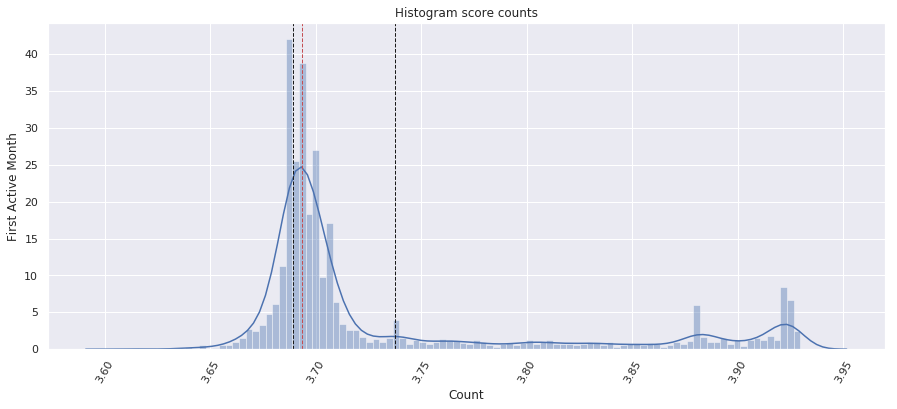

In [13]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.distplot(df_lb_sorted['Score'][:index_of_last_10_percent].values, bins=100)
plt.title('Histogram score counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('First Active Month')
plt.axvline(df_lb_sorted['Score'].iloc[ms], color="r", linestyle="--", linewidth=1)
plt.axvline(df_lb_sorted['Score'].iloc[q1_tr], color="k", linestyle="--", linewidth=1)
plt.axvline(df_lb_sorted['Score'].iloc[q3_tr], color="k", linestyle="--", linewidth=1)
plt.show()

**Red dashed vertical** line denotes my current position and the **black dashed vertical** lines denote the 1st and 3rd quartile. 

## Submission

In [14]:
submission_params = re.findall(r"\/(.*" + submission_score + "([0-9\.]{7}).*\.csv)", submission_csv)

submission_public_score = str(submission_params[0][1]) if len(submission_params) > 0 else submission_csv[submission_csv.index('/')+1:]
submission_file = str(submission_params[0][0]) if len(submission_params) > 0 else submission_csv[submission_csv.index('/')+1:]

In [15]:
def convert_to_df(csv):
    df = pd.DataFrame(data=csv)[0].str.split(',',expand=True)  
    header = df.iloc[0]
    df = df[1:]
    df.columns = header
    return df

In [16]:
api.competition_submit(submission_csv, submission_score + ' score: ' + submission_score, kaggle_selected_competition)

100%|██████████| 4.24M/4.24M [00:07<00:00, 624kB/s] 


Successfully submitted to Elo Merchant Category Recommendation

In [17]:
#submissions_csv = api.competition_submissions_cli(kaggle_selected_competition, csv_display=True, quiet=True)
submissions_csv = !kaggle competitions submissions $kaggle_selected_competition -v
df_submissions = convert_to_df(submissions_csv)

In [18]:
df_submissions[:5]

,fileName,date,description,status,publicScore,privateScore,None
1,stacked_CV3.65492.csv,2019-03-11 09:58:52,CV score: 3.65492,complete,3.70587,3.63021,None
2,stacked_wavg_3.654925.csv,2019-03-08 15:16:04,Test message,complete,3.70587,3.63021,None
3,stacked_wavg_3.654925.csv,2019-03-08 10:44:21,Test message,complete,3.70587,3.63021,None
4,stacked_wavg_3.654925.csv,2019-03-08 10:42:57,Test message,complete,3.70587,3.63021,None
5,stacked_3.652103.csv,2019-02-26 19:46:07,"""LightGBM + XGBoost + CatBoost stacking + Lynx...",None,None,None,None


In [19]:
credentials = None

# Authentication
if os.path.exists('credentials/token.pickle'):
    with open('credentials/token.pickle', 'rb') as token:
        credentials = pickle.load(token)

# If there are no (valid) credentials available, let the user log in.
if not credentials or not credentials.valid:
    if credentials and credentials.expired and credentials.refresh_token:
        credentials.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('credentials/credentials.json', ['https://www.googleapis.com/auth/spreadsheets'])
        credentials = flow.run_local_server()
    # Save the credentials for the next run
    with open('credentials/token.pickle', 'wb') as token:
        pickle.dump(credentials, token)

service = build('sheets', 'v4', credentials=credentials)

# Read cells
result = service.spreadsheets().values().get(spreadsheetId=google_spreasheet_id, range='A2:A200').execute()
numRows = result.get('values') if result.get('values') is not None else 0
rowNumber = int(np.concatenate(numRows).astype(int).max() + 1)

# Append cells
value_range_body = {"values":[[rowNumber, kaggle_user_name, str(datetime.now())[:19], submission_public_score, df_submissions['publicScore'][1], submission_file, submission_notebook]]}

request = service.spreadsheets().values().append(spreadsheetId=google_spreasheet_id, range='A2:G2', valueInputOption='RAW', insertDataOption='INSERT_ROWS', body=value_range_body)
response = request.execute()

pprint(response)

{'spreadsheetId': '1Pww0KEQKb2bbTUE4-DODV8RTqSnFbXwQqXUESQLOZ3I',
 'tableRange': 'Sheet1!A1:F2',
 'updates': {'spreadsheetId': '1Pww0KEQKb2bbTUE4-DODV8RTqSnFbXwQqXUESQLOZ3I',
             'updatedCells': 6,
             'updatedColumns': 6,
             'updatedRange': 'Sheet1!A3:F3',
             'updatedRows': 1}}


In [22]:
z = zipfile.ZipFile("archives/" + submission_file + ".zip", "w")
z.write(submission_csv)
if (submission_notebook != ""):
    z.write(submission_notebook)
z.close()

z.printdir()

File Name                                             Modified             Size
input/stacked_CV3.65492.csv                    2019-02-25 16:12:30      4443818
